In [74]:
# from google.colab import drive
# drive.mount('/content/drive')

In [75]:
!ls

frcnn_test_resnet.ipynb
frcnn_test_resnet_model_1_hier.ipynb
frcnn_test_resnet_model_2_hier.ipynb
frcnn_test_resnet_model_2_hier_per_soort.ipynb
frcnn_test_resnet_model_2_hier_per_soort_nieuwe_f.ipynb
frcnn_test_resnet_model_3_hier.ipynb
frcnn_test_resnet_model_hier.ipynb
frcnn_test_resnet_model_test_hier.ipynb
frcnn_test_resnet_model_test_hier_nieuwe_waarde.ipynb
frcnn_train_resnet.ipynb
frcnn_train_resnet_model_1_hier.ipynb
frcnn_train_resnet_model_2_hier.ipynb
frcnn_train_resnet_model_3_hier.ipynb
frcnn_train_resnet_model_hier.ipynb
frcnn_train_resnet_model_test_hier.ipynb
model
model_1
model_2
model_2_frcnn_test_RPN_hier_per_soort.ipynb
model_2_test_verslag.ipynb
model_3
model_4
model_4_frcnn_train_resnet_hier.ipynb
model_4_test_algemeen.ipynb
model_4_test_per_soort_en_algemeen.ipynb
model_4_vorm_om.ipynb
model_5
model_5_frcnn_train_extra_33.ipynb
model_5_test_algemeen.ipynb
model_5_test_per_soort.ipynb
model_5_vorm_om.ipynb
model_6
model_6_test_niet_omgevormd.ipynb
model_6_train_n

### Import libs

In [76]:
import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [77]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import pprint
import shutil
import sys
import time
import numpy as np
import pickle
import math
import cv2

import copy



from matplotlib import pyplot as plt
import tensorflow as tf

import pandas as pd


from tensorflow import keras

from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam, SGD, RMSprop


from tensorflow.keras.layers import Flatten, Dense, Input, MaxPooling2D, Dropout, Activation, ZeroPadding2D, \
    BatchNormalization, \
    Conv2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed, AveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras import initializers, regularizers

from zipfile import ZipFile


#### Config setting

In [78]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'resnet50'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
		# Note that if im_size is smaller, anchor_box_scales should be scaled
		# Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256]   
		# Anchor box ratios
		#self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
		self.anchor_box_ratios = [[1, 1], [0.75, 0.75], [1.25, 1.25]]
        
		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 16

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [79]:
def get_data(input_path):
	"""Parse the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [80]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = 'tf'
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        print('input_shape[0][3]',input_shape[0][3])
        print('input_shape[0][1]',input_shape[0][1])
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)
        
        print('input_shape',input_shape)
        
        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)

        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Identity Block

In [81]:
# identity_block

def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    kernel_size -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters


    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, input_tensor]) 
    X = Activation('relu')(X)

    return X

In [82]:
def identity_block_td(input_tensor, kernel_size, filters, stage, block, trainable=True):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    kernel_size -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters


    # First component of main path
    X = TimeDistributed(Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2a')(input_tensor)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = TimeDistributed(Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2b')(X)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = TimeDistributed(Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2c')(X)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, input_tensor]) 
    X = Activation('relu')(X)

    return X

# Conv Block
## Conv block

In [83]:
def convolutional_block(input_tensor, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # HIER Conv2D(F1,(3,3)) veranderd naar (1,1)
    # First component of main path 
    X = Conv2D(F1, (1 ,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(input_tensor)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## Conv block td
conv block time distributed

In [84]:
def convolutional_block_td(input_tensor, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    input_tensor -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    bn_axis = 3
    
    # Retrieve Filters
    F1, F2, F3 = filters


    # First component of main path 
    X = TimeDistributed(Conv2D(F1, (1,1), strides = (s,s), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2a')(input_tensor)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = TimeDistributed(Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2b')(X)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = TimeDistributed(Conv2D(F3, (1, 1), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '2c')(X)
    X = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '2c')(X)

    X_shortcut = TimeDistributed(Conv2D(F3, (1,1), strides = (s,s), padding = 'same', kernel_initializer = glorot_uniform(seed=0)), name = conv_name_base + '1')(input_tensor)
    X_shortcut = TimeDistributed(BatchNormalization(axis = 3), name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Build Model

In [85]:
# print(K.common.image_dim_ordering())

#### Resnet50 model


In [86]:
def get_img_output_length(width, height):
    #function to calculate final layer's feature map (of base model) size according to input image size
    def get_output_length(input_length):
        input_float = input_length + 0.0
        test = math.ceil(input_float/16) 
        # //16 omdat we 4 lagen hebben die telkens halveren (/2)
#         test = input_length//16
        #print('input_float',input_float)
        #print('test',test)
        return test
    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):

    input_shape = (None, None, 3)
    
    classes = 1

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    bn_axis = 3


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(img_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    #X = MaxPooling2D((2, 2), strides=(2, 2), name='BLOCK_4')(X)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


#     # Stage 5 (≈3 lines)
#     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    ####################################
    # Dit moet nog uit commentaar
    # Alleen de Flatten
    #X = Flatten()(X)
    
    # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    # model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return X

####  RPN layer

In [87]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """


    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

#### Classifier_layer

In [88]:
def classifier_layers(X, input_shape):
    # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround
    # (hence a smaller stride in the region that follows the ROI pool)
    #X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    
    X = convolutional_block_td(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s = 2)
    
    X = identity_block_td(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block_td(X, 3, [512, 512, 2048], stage=5, block='c')
    X = TimeDistributed(AveragePooling2D((2,2)), name='avg_pool')(X)

    return X

### Classifier


In [89]:
def classifier_model(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7
    

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    
    out = classifier_layers(out_roi_pool, input_shape=input_shape)

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]
    

#### Calculate IoU (Intersection of Union)

In [90]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [91]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)
# 	print('resized_width',resized_width)
# 	print('resized_height',resized_height)
# 	print('output_width',output_width)
# 	print('output_height',output_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):
				# x-coordinates of the current anchor box
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2
				
				# ignore boxes that go across image boundaries
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [92]:
def get_new_img_size(width, height, img_min_side=600):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

# All commented because the augmentation is already done

# 	#if augment:
# 	if False:
# 		rows, cols = img.shape[:2]

# 		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
# 			img = cv2.flip(img, 1)
# 			for bbox in img_data_aug['bboxes']:
# 				x1 = bbox['x1']
# 				x2 = bbox['x2']
# 				bbox['x2'] = cols - x1
# 				bbox['x1'] = cols - x2

# 		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
# 			img = cv2.flip(img, 0)
# 			for bbox in img_data_aug['bboxes']:
# 				y1 = bbox['y1']
# 				y2 = bbox['y2']
# 				bbox['y2'] = rows - y1
# 				bbox['y1'] = rows - y2

# 		if config.rot_90:
# 			angle = np.random.choice([0,90,180,270],1)[0]
# 			if angle == 270:
# 				img = np.transpose(img, (1,0,2))
# 				img = cv2.flip(img, 0)
# 			elif angle == 180:
# 				img = cv2.flip(img, -1)
# 			elif angle == 90:
# 				img = np.transpose(img, (1,0,2))
# 				img = cv2.flip(img, 1)
# 			elif angle == 0:
# 				pass

# 			for bbox in img_data_aug['bboxes']:
# 				x1 = bbox['x1']
# 				x2 = bbox['x2']
# 				y1 = bbox['y1']
# 				y2 = bbox['y2']
# 				if angle == 270:
# 					bbox['x1'] = y1
# 					bbox['x2'] = y2
# 					bbox['y1'] = cols - x2
# 					bbox['y2'] = cols - x1
# 				elif angle == 180:
# 					bbox['x2'] = cols - x1
# 					bbox['x1'] = cols - x2
# 					bbox['y2'] = rows - y1
# 					bbox['y1'] = rows - y2
# 				elif angle == 90:
# 					bbox['x1'] = rows - y2
# 					bbox['x2'] = rows - y1
# 					bbox['y1'] = x1
# 					bbox['y2'] = x2        
# 				elif angle == 0:
# 					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [93]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
				# Aangepast -> We willen geen augmentatie doen                 
					img_data_aug, x_img = augment(img_data, C, augment=False)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

#### Define loss functions for all four outputs

In [94]:
lambda_rpn_regr = 1
lambda_rpn_class = 1

lambda_cls_regr = 2
lambda_cls_class = 1.0

epsilon = 1e-4

In [95]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [96]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=80):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [97]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=80,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



### Start training

In [98]:
base_path = 'model_5/'

test_path = '../../data/text_files/deel_1_tot_5_training.txt' # Training data (annotation file)
train_path = '../../data/text_files/deel_1_tot_5_training.txt' # Directory to save the test images

num_rois = 16 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = False # Augment with horizontal flips in training. 
vertical_flips = False   # Augment with vertical flips in training. 
rot_90 = False           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model_frcnn_resnet.hdf5')

record_path = os.path.join(base_path, 'record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(base_path, 'resnet_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(base_path, 'model_resnet_config.pickle')

In [99]:
# Create the config
C = Config()

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [100]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
print('train_path',train_path)
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

train_path ../../data/text_files/deel_1_tot_5_training.txt
Parsing annotation files
idx=22628
Spend 1.34 mins to load the data


In [101]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'bg': 0, 'huidmond': 22628}
Num classes (including bg) = 2
{'huidmond': 0, 'bg': 1}
Config has been written to model_5/model_resnet_config.pickle, and can be loaded when testing to ensure correct results


In [102]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 10722


In [104]:
array_namen_lage_F1 =  ['Calla palustris', 'Allium moly B', 'Garcinia punctata', 'Sarcochilus fitzgeraldii', 'Restrepiella ophiocephala', 'Aristolochia clementitis', 'Habenaria medusa', 'Pentaclethra macrophylla', 'Paphiopedilum randsii', 'Amorphophallus titanum', 'Lannea welwitschii', 'Poa pratensis', 'Chloris gayana', 'Strychnos spinosa', 'Oxalis fontana', 'Euphorbia nivulia B', 'Lilium regale', 'Eria globifera', 'Polyalthia suaveolens', 'Potentilla reptans', 'Geitonoplesium cymosum', 'Strychnos cocculoides', 'Diospyros mespiliformis', 'Diospyros bipindensis', 'Euphorbia spinescens B', 'Irvingia grandifolia', 'Prioria oxyphylla', 'Ajuga reptans', 'Prioria balsamifera', 'Alpinia sanderae', 'Diospyros kirkii', 'Lannea schweinfurthii Bidgood 1759', 'Nymphaea Director G (B)']

In [ ]:
opslag_train_imgs = train_imgs

In [106]:
print(len(opslag_train_imgs))

10722


In [107]:
train_aantal = int(len(opslag_train_imgs)*0.9)
train_imgs = opslag_train_imgs[0:train_aantal]

print(len(train_imgs))

9649


In [109]:
extra_train = []
minder_train = []
for namen in train_imgs:
    naam = namen['filepath'].split('.')
    deel_naam = naam[-2].split('/')
    e_naam = deel_naam[-1].split('_')
    plaats = 0
    opslag = 0
    for deel in e_naam:
        if len(deel)>5 and opslag == 0:
            uiteindelijke_plaats = plaats
            opslag = 1
        plaats+=1
    filename = e_naam[uiteindelijke_plaats]
    gevonden = 0
    for slecht_f1_naam in array_namen_lage_F1:
        if slecht_f1_naam == filename:
            extra_train.append(namen)
            gevonden = 1
    if gevonden == 0:
        minder_train.append(namen)

In [111]:
print(len(extra_train))
print(len(minder_train))

2478
7171


In [112]:
train_imgs_totaal = []
len_minder_train = int(len(minder_train)*0.7956)
minder_train = minder_train[0:len_minder_train]
train_imgs_totaal = minder_train
for t_img in extra_train:
    train_imgs_totaal.append(t_img)

len_extra = int(len(extra_train)*0.5913)
extra_train = extra_train[0:len_extra]

for t_img in extra_train:
    train_imgs_totaal.append(t_img)

In [113]:
print(len(train_imgs_totaal))

9648


In [114]:
train_imgs = train_imgs_totaal

In [115]:
lengte_train_imgs = len(train_imgs)
lengte_train = lengte_train_imgs * 0.9
lengte_train = int(lengte_train)

print('leng_train',lengte_train)
print('totale lengte',len(train_imgs))

leng_train 8683
totale lengte 9648


In [116]:
train_imgs_save = train_imgs

In [117]:
print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 9648


In [120]:
random.seed(1)
random.shuffle(train_imgs)


In [121]:
test_imgs, classes_count_test, class_mapping_test = get_data(test_path)

Parsing annotation files
idx=22628

In [122]:
random.seed(1)
random.shuffle(test_imgs)

test_imgs = train_imgs_save[lengte_train:len(train_imgs_save)]
print('Num train samples (images) {}'.format(len(test_imgs)))

Num train samples (images) 965


In [124]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

In [125]:
# Get train data generator which generate X, Y, image_data
data_gen_test = get_anchor_gt(test_imgs, C, get_img_output_length, mode='test')

#### Explore 'data_gen_train'

data_gen_train is an **generator**, so we get the data by calling **next(data_gen_train)**

In [126]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=800 width=600
Resized image:  height=800 width=600 C.im_size=600
Feature map size: height=50 width=38 C.rpn_stride=16
X.shape (1, 800, 600, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 50, 38, 18)
Shape of y_rpn_regr (1, 50, 38, 72)
image_data {'filepath': '../../data/augmentatie/finale_opdeling/deel_5_4_training/RB_H_1_Octorneria bauenlla_19074085-_leaf1-field3.jpg', 'width': 600, 'height': 800, 'bboxes': [{'class': 'huidmond', 'x1': 231, 'x2': 411, 'y1': 568, 'y2': 766}]}
Number of positive anchors for this image: 14
debug_num_pos!=0
y_rpn_cls for possible pos anchor: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          1.          1.          1.
  0.          0.          0.   

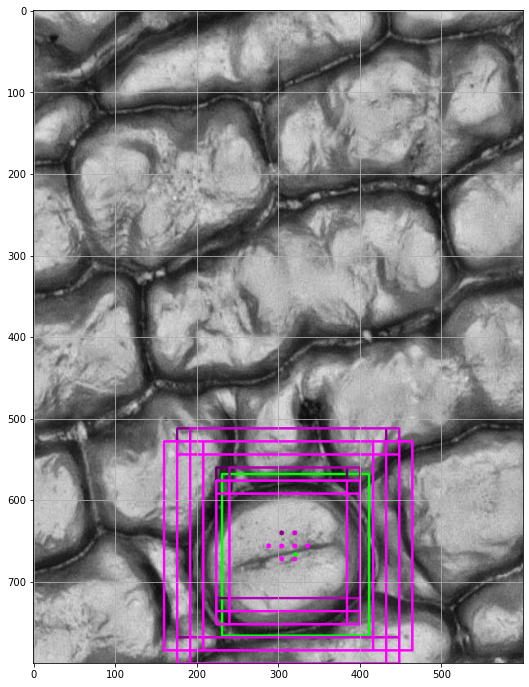

In [127]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print('X.shape',X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print('image_data',image_data)


print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    print('debug_num_pos==0')
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    print('debug_num_pos!=0')
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    #print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    #print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    
    img = debug_img.copy()
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # zelf in commentaar gezet
    color = (0, 255, 0)
#     plt.figure(figsize=(10,10))
#     plt.grid()
#     plt.imshow(img)
#     plt.show()
    print('\n')
    print('\n')
    for bboxs in image_data['bboxes']:
        gt_x1, gt_x2 = bboxs['x1']*(X.shape[2]/image_data['width']), bboxs['x2']*(X.shape[2]/image_data['width'])
        gt_y1, gt_y2 = bboxs['y1']*(X.shape[1]/image_data['height']), bboxs['y2']*(X.shape[1]/image_data['height'])
        gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
        cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
        cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
        #print(bboxs)
    
    
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)


    # Draw positive anchors according to the y_rpn_regr
    test_count = 0
    #print('Y:', Y[0][0][5])
    #print('Y:', Y[1][0][5])
    
    print('debug_num_pos:',debug_num_pos)
    for i in range(debug_num_pos):
        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        if(int(idx/3)>2):
            idx=7
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]
        
        test_count +=1
        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(12,12))
plt.grid()
plt.imshow(img)
plt.show()

In [128]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_test)

Original image: height=600 width=800
Resized image:  height=600 width=800 C.im_size=600
Feature map size: height=38 width=50 C.rpn_stride=16
X.shape (1, 600, 800, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 38, 50, 18)
Shape of y_rpn_regr (1, 38, 50, 72)
Number of positive anchors for this image: 17
debug_num_pos!=0
y_rpn_cls for possible pos anchor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          1.          1.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

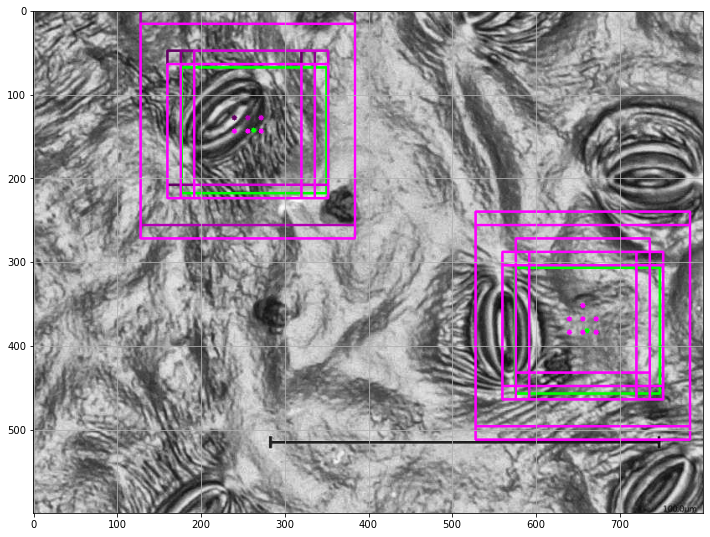

In [129]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print('X.shape',X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))


print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    print('debug_num_pos==0')
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    print('debug_num_pos!=0')
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    
    img = debug_img.copy()
    color = (0, 255, 0)
    print('\n')
    print('\n')
    for bboxs in image_data['bboxes']:
        gt_x1, gt_x2 = bboxs['x1']*(X.shape[2]/image_data['width']), bboxs['x2']*(X.shape[2]/image_data['width'])
        gt_y1, gt_y2 = bboxs['y1']*(X.shape[1]/image_data['height']), bboxs['y2']*(X.shape[1]/image_data['height'])
        gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
        cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
        cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
    
    
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Draw positive anchors according to the y_rpn_regr
    test_count = 0
    
    print('debug_num_pos:',debug_num_pos)
    for i in range(debug_num_pos):
        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        if(int(idx/3)>2):
            idx=7
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]
        
        test_count +=1
        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(12,12))
plt.grid()
plt.imshow(img)
plt.show()

#### Build the model

In [130]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [131]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)
print('shared_layers',shared_layers)

classifier = classifier_model(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

print('rpn[:2]',rpn[:2])

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)


tel_layer = 0
for layer in model_rpn.layers:
    if tel_layer<80:        
        layer.trainable = False
    else:
        layer.trainable = True
    tel_layer +=1
    
    
for layer in model_rpn.layers:
    print(layer, layer.trainable)

print('model_classifier')
for layer in model_classifier.layers:
    print(layer, layer.trainable)


# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

#model_all.summary()

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP','mean_overlapping_bboxes_test', 'class_acc_test', 'loss_rpn_cls_test', 'loss_rpn_regr_test', 'loss_class_cls_test', 'loss_class_regr_test', 'curr_loss_test', 'elapsed_time_test', 'mAP_test'])
#     record_df_test = pd.DataFrame(columns=['mean_overlapping_bboxes_test', 'class_acc_test', 'loss_rpn_cls_test', 'loss_rpn_regr_test', 'loss_class_cls_test', 'loss_class_regr_test', 'curr_loss_test', 'elapsed_time_test', 'mAP_test'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']
    
    r_mean_overlapping_bboxes_test = record_df['mean_overlapping_bboxes_test']
    r_class_acc_test = record_df['class_acc_test']
    r_loss_rpn_cls_test = record_df['loss_rpn_cls_test']
    r_loss_rpn_regr_test = record_df['loss_rpn_regr_test']
    r_loss_class_cls_test = record_df['loss_class_cls_test']
    r_loss_class_regr_test = record_df['loss_class_regr_test']
    r_curr_loss_test = record_df['curr_loss_test']
    r_elapsed_time_test = record_df['elapsed_time_test']
    r_mAP_test = record_df['mAP_test']

    print('Already train %dK batches'% (len(record_df)))

shared_layers Tensor("activation_88/Identity:0", shape=(None, None, None, 1024), dtype=float32)
input_shape[0][3] 1024
input_shape[0][1] None
input_shape Tensor("roi_pooling_conv_1/Shape:0", shape=(4,), dtype=int32)
rpn[:2] [<tf.Tensor 'rpn_out_class_1/Identity:0' shape=(None, None, None, 9) dtype=float32>, <tf.Tensor 'rpn_out_regress_1/Identity:0' shape=(None, None, None, 36) dtype=float32>]
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2adf2015d0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f2ad81b8b50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2adf201e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2ade88a490> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f2b346eb450> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2adeee39d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2adf60bd

Already train 300K batches


In [136]:
optimizer = Adam(lr=1e-4)
optimizer_classifier = Adam(lr=1e-4)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [137]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 965
epoch_length_test = 96
num_epochs = 100
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [138]:
print(len(record_df))

300


In [ ]:
start_time = time.time()
# print('A')
model_opgeslaan = 0
model_tel = 0
testen = True
for epoch_num in range(num_epochs):


    progbar = tf.keras.utils.Progbar(epoch_length)
    progbar_test = tf.keras.utils.Progbar(epoch_length_test)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    r_epochs += 1
    

    while True:        
        try:
            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)
        

            # Train rpn model and get loss value [loss, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, 'tf', use_regr=True, overlap_thresh=0.7, max_boxes=80)
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)
            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)
#             print('L')
            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []
#             print('M')
            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos

            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
#      
            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_class_cls + loss_class_regr + loss_rpn_cls + loss_rpn_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)
                    model_opgeslaan+=1
                    
                if model_opgeslaan == 0 and model_tel == 2:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                        print('Hier toch het model opgeslaan aangezien het na 5 keer nog niet verbeterd is')
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)
                    model_opgeslaan+=1
                    
                model_tel += 1

###########################################################################################################   
##################### Till here we were training on the training data 
##################### Now we will validata. This part doesn't change the weights in the model 
##################### But it is possible to see if we are overfitting 
##################### The code is the same as above. But without saving the weights


                print('curr_loss',curr_loss) 
                print('best_loss',best_loss)                     
                if testen == True:   #curr_loss == best_loss:
                
                    print('We will validate')
####################
                    while True:       
                        try:
                            if len(rpn_accuracy_rpn_monitor) == epoch_length_test and C.verbose:
                                mean_overlapping_bboxes_test = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                                rpn_accuracy_rpn_monitor = []
                                print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                                if mean_overlapping_bboxes_test == 0:
                                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

                            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_test)    
                            # Train rpn model and get loss value [loss, loss_rpn_cls, loss_rpn_regr]
                            loss_rpn = model_rpn.train_on_batch(X, Y)
                            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
                            P_rpn = model_rpn.predict_on_batch(X)

                            # R: bboxes (shape=(300,4))
                            # Convert rpn layer to roi bboxes
                            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, 'tf', use_regr=True, overlap_thresh=0.7, max_boxes=300)
                            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
                            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
                            # Y1: one hot code for bboxes from above => x_roi (X)
                            # Y2: corresponding labels and corresponding gt bboxes
                            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)
                            # If X2 is None means there are no matching bboxes
                            if X2 is None:
                                rpn_accuracy_rpn_monitor.append(0)
                                rpn_accuracy_for_epoch.append(0)
                                continue
                            # Find out the positive anchors and negative anchors
                            neg_samples = np.where(Y1[0, :, -1] == 1)
                            pos_samples = np.where(Y1[0, :, -1] == 0)
                            if len(neg_samples) > 0:
                                neg_samples = neg_samples[0]
                            else:
                                neg_samples = []

                            if len(pos_samples) > 0:
                                pos_samples = pos_samples[0]
                            else:
                                pos_samples = []
                            rpn_accuracy_rpn_monitor.append(len(pos_samples))
                            rpn_accuracy_for_epoch.append((len(pos_samples)))

                            if C.num_rois > 1:
                                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                                if len(pos_samples) < C.num_rois//2:
                                    selected_pos_samples = pos_samples.tolist()
                                else:
                                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                                # Randomly choose (num_rois - num_pos) neg samples
                                try:
                                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                                except:
                                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                                # Save all the pos and neg samples in sel_samples
                                sel_samples = selected_pos_samples + selected_neg_samples
                            else:
                                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                                selected_pos_samples = pos_samples.tolist()
                                selected_neg_samples = neg_samples.tolist()
                                if np.random.randint(0, 2):
                                    sel_samples = random.choice(neg_samples)
                                else:
                                    sel_samples = random.choice(pos_samples)

                            # training_data: [X, X2[:, sel_samples, :]]
                            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
                            #  X                     => img_data resized image
                            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
                            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
                            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos

                            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
                            #print("Test2")
                            losses[iter_num, 0] = loss_rpn[1]
                            losses[iter_num, 1] = loss_rpn[2]

                            losses[iter_num, 2] = loss_class[1]
                            losses[iter_num, 3] = loss_class[2]
                            losses[iter_num, 4] = loss_class[3]

                            iter_num += 1

                            progbar_test.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
           
                            if iter_num == epoch_length_test:
                                loss_rpn_cls_test = np.mean(losses[:, 0])
                                loss_rpn_regr_test = np.mean(losses[:, 1])
                                loss_class_cls_test = np.mean(losses[:, 2])
                                loss_class_regr_test = np.mean(losses[:, 3])
                                class_acc_test = np.mean(losses[:, 4])

                                mean_overlapping_bboxes_test = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                                rpn_accuracy_for_epoch = []

                                if C.verbose:
                                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes test: {}'.format(mean_overlapping_bboxes_test))
                                    print('Classifier accuracy for bounding boxes from RPN test: {}'.format(class_acc_test))
                                    print('Loss RPN classifier test: {}'.format(loss_rpn_cls_test))
                                    print('Loss RPN regression test: {}'.format(loss_rpn_regr_test))
                                    print('Loss Detector classifier test: {}'.format(loss_class_cls_test))
                                    print('Loss Detector regression test: {}'.format(loss_class_regr_test))
                                    print('Total loss test: {}'.format(loss_rpn_cls_test + loss_rpn_regr_test + loss_class_cls_test + loss_class_regr_test))
                                    print('Elapsed time test: {}'.format(time.time() - start_time))
                                    elapsed_time_test = (time.time()-start_time)/60

                                curr_loss_test = loss_class_cls_test + loss_class_regr_test + loss_rpn_cls_test + loss_rpn_regr_test
                                iter_num = 0
                                start_time = time.time()

                                break
        
                        except Exception as e:
                            print("FOUT lijn bij testen")
                            print('Exception: {}'.format(e))
                            continue
################   
                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0,
                           'mean_overlapping_bboxes_test':round(mean_overlapping_bboxes_test, 3), 
                           'class_acc_test':round(class_acc_test, 3), 
                           'loss_rpn_cls_test':round(loss_rpn_cls_test, 3), 
                           'loss_rpn_regr_test':round(loss_rpn_regr_test, 3), 
                           'loss_class_cls_test':round(loss_class_cls_test, 3), 
                           'loss_class_regr_test':round(loss_class_regr_test, 3), 
                           'curr_loss_test':round(curr_loss_test, 3), 
                           'elapsed_time_test':round(elapsed_time_test, 3), 
                           'mAP_test': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)           
                break

####.###########                    
                
        except Exception as e:
            print("FOUT lijn einde")
            print('Exception: {}'.format(e))
            continue
try:
    if model_opgeslaan == 0:
        print('De training heeft het model niet verbeterd. Er werd dus geen beter model opgeslaan')
        print('maar handmatig het laatste model toch opgeslaan')
        model_all.save_weights(C.model_path)
except:
    print('niet gelukt om model op te slaan')

print('Training complete, exiting.')
print('model X keer opgeslaan',model_opgeslaan)

Epoch 301/400
input_shape Tensor("model_4/roi_pooling_conv_1/Shape:0", shape=(4,), dtype=int32)
input_shape Tensor("model_4/roi_pooling_conv_1/Shape:0", shape=(4,), dtype=int32)
193/965 [=====>........................] - ETA: 23:40 - rpn_cls: 0.0170 - rpn_regr: 0.0091 - final_cls: 0.9978 - final_regr: 0.5651FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
327/965 [=========>....................] - ETA: 14:11 - rpn_cls: 0.0221 - rpn_regr: 0.0098 - final_cls: 0.7446 - final_regr: 0.4686FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
359/965 [==========>...................] - ETA: 12:49 - rpn_cls: 0.0226 - rpn_regr: 0.0099 - final_cls: 0.7077 - final_regr: 0.4511FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
464/965 [=============>................] - ETA: 9:26 - rpn_cls: 0.0259 - rpn_regr: 0.0102 - final_cls: 0.6169 - final_regr: 0.4035FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken

curr_loss 0.33312042910710493
best_loss 0.33312042910710493
We gaan nu valideren
96/96 [==============================] - 640s 7s/step - rpn_cls: 0.0219 - rpn_regr: 0.0098 - final_cls: 0.1151 - final_regr: 0.0698
Mean number of bounding boxes from RPN overlapping ground truth boxes test: 13.690721649484535
Classifier accuracy for bounding boxes from RPN test: 0.9248704663212435
Loss RPN classifier test: 0.04480999155570178
Loss RPN regression test: 0.01193950194714668
Loss Detector classifier test: 0.18214186012495787
Loss Detector regression test: 0.08561090770047254
Total loss test: 0.32450226132827886
Elapsed time test: 62.408555030822754
t
Epoch 304/400
126/965 [==>...........................] - ETA: 8:36 - rpn_cls: 0.0665 - rpn_regr: 0.0107 - final_cls: 0.2317 - final_regr: 0.0831FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
408/965 [===========>..................] - ETA: 5:42 - rpn_cls: 0.0640 - rpn_regr: 0.0112 - final_cls: 0.1979 - final_regr: 0.085

89/96 [==========================>...] - ETA: 50s - rpn_cls: 0.0154 - rpn_regr: 0.0093 - final_cls: 0.1306 - final_regr: 0.0651FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
96/96 [==============================] - 642s 7s/step - rpn_cls: 0.0158 - rpn_regr: 0.0093 - final_cls: 0.1326 - final_regr: 0.0654
Mean number of bounding boxes from RPN overlapping ground truth boxes test: 12.877551020408163
Classifier accuracy for bounding boxes from RPN test: 0.9233808290155441
Loss RPN classifier test: 0.03653927046669165
Loss RPN regression test: 0.012191245576862603
Loss Detector classifier test: 0.1821095030588929
Loss Detector regression test: 0.08281311023343413
Total loss test: 0.3136531293358813
Elapsed time test: 55.23678994178772
t
Epoch 309/400
318/965 [========>.....................] - ETA: 6:57 - rpn_cls: 0.0134 - rpn_regr: 0.0118 - final_cls: 0.1813 - final_regr: 0.0820FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
357/9

468/965 [=============>................] - ETA: 4:59 - rpn_cls: 0.0407 - rpn_regr: 0.0130 - final_cls: 0.1675 - final_regr: 0.0770FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
477/965 [=============>................] - ETA: 4:54 - rpn_cls: 0.0405 - rpn_regr: 0.0130 - final_cls: 0.1675 - final_regr: 0.0770FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
551/965 [================>.............] - ETA: 4:08 - rpn_cls: 0.0391 - rpn_regr: 0.0129 - final_cls: 0.1679 - final_regr: 0.0771FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
554/965 [================>.............] - ETA: 4:06 - rpn_cls: 0.0391 - rpn_regr: 0.0129 - final_cls: 0.1679 - final_regr: 0.0771FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
669/965 [===================>..........] - ETA: 3:00 - rpn_cls: 0.0374 - rpn_regr: 0.0128 - final_cls: 0.

812/965 [========================>.....] - ETA: 1:32 - rpn_cls: 0.0358 - rpn_regr: 0.0118 - final_cls: 0.1705 - final_regr: 0.0784FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
842/965 [=========================>....] - ETA: 1:14 - rpn_cls: 0.0355 - rpn_regr: 0.0118 - final_cls: 0.1703 - final_regr: 0.0784FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
883/965 [==========================>...] - ETA: 49s - rpn_cls: 0.0350 - rpn_regr: 0.0118 - final_cls: 0.1701 - final_regr: 0.0784FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
885/965 [==========================>...] - ETA: 48s - rpn_cls: 0.0350 - rpn_regr: 0.0118 - final_cls: 0.1700 - final_regr: 0.0784FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
930/965 [===========================>..] - ETA: 21s - rpn_cls: 0.0345 - rpn_regr: 0.0118 - final_cls: 0.1697 - final_regr: 0.0784FOUT lijn einde
Exception: 'a' cannot be empty unless

630/965 [==================>...........] - ETA: 3:23 - rpn_cls: 0.0250 - rpn_regr: 0.0129 - final_cls: 0.1668 - final_regr: 0.0802FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
650/965 [===================>..........] - ETA: 3:10 - rpn_cls: 0.0250 - rpn_regr: 0.0129 - final_cls: 0.1664 - final_regr: 0.0801FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
750/965 [======================>.......] - ETA: 2:12 - rpn_cls: 0.0256 - rpn_regr: 0.0128 - final_cls: 0.1654 - final_regr: 0.0798FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
796/965 [=======================>......] - ETA: 1:44 - rpn_cls: 0.0259 - rpn_regr: 0.0129 - final_cls: 0.1652 - final_regr: 0.0798FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
886/965 [==========================>...] - ETA: 49s - rpn_cls: 0.0263 - rpn_regr: 0.0129 - final_cls: 0.1648 - final_regr: 0.0797FOUT lijn einde
Exception: 'a' cannot be empty unle

 78/965 [=>............................] - ETA: 8:52 - rpn_cls: 0.0104 - rpn_regr: 0.0138 - final_cls: 0.1430 - final_regr: 0.0710FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
225/965 [=====>........................] - ETA: 7:34 - rpn_cls: 0.0219 - rpn_regr: 0.0132 - final_cls: 0.1482 - final_regr: 0.0740FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
256/965 [======>.......................] - ETA: 7:20 - rpn_cls: 0.0228 - rpn_regr: 0.0132 - final_cls: 0.1493 - final_regr: 0.0742FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
268/965 [=======>......................] - ETA: 7:10 - rpn_cls: 0.0232 - rpn_regr: 0.0132 - final_cls: 0.1498 - final_regr: 0.0742FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
366/965 [==========>...................] - ETA: 6:10 - rpn_cls: 0.0261 - rpn_regr: 0.0134 - final_cls: 0.1532 - final_regr: 0.0745FOUT lijn einde
Exception: 'a' cannot be empty unl

401/965 [===========>..................] - ETA: 5:43 - rpn_cls: 0.0068 - rpn_regr: 0.0114 - final_cls: 0.1687 - final_regr: 0.0709FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
444/965 [============>.................] - ETA: 5:19 - rpn_cls: 0.0077 - rpn_regr: 0.0115 - final_cls: 0.1686 - final_regr: 0.0710FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
554/965 [================>.............] - ETA: 4:08 - rpn_cls: 0.0096 - rpn_regr: 0.0117 - final_cls: 0.1690 - final_regr: 0.0717FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
665/965 [===================>..........] - ETA: 3:01 - rpn_cls: 0.0112 - rpn_regr: 0.0119 - final_cls: 0.1688 - final_regr: 0.0721FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
762/965 [======================>.......] - ETA: 2:03 - rpn_cls: 0.0123 - rpn_regr: 0.0120 - final_cls: 0.1687 - final_regr: 0.0723FOUT lijn einde
Exception: 'a' cannot be empty unl

560/965 [================>.............] - ETA: 4:02 - rpn_cls: 0.0345 - rpn_regr: 0.0124 - final_cls: 0.1580 - final_regr: 0.0766FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
695/965 [====================>.........] - ETA: 2:40 - rpn_cls: 0.0332 - rpn_regr: 0.0125 - final_cls: 0.1572 - final_regr: 0.0763FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
716/965 [=====================>........] - ETA: 2:28 - rpn_cls: 0.0330 - rpn_regr: 0.0125 - final_cls: 0.1571 - final_regr: 0.0763FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
720/965 [=====================>........] - ETA: 2:26 - rpn_cls: 0.0329 - rpn_regr: 0.0125 - final_cls: 0.1570 - final_regr: 0.0763FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
725/965 [=====================>........] - ETA: 2:23 - rpn_cls: 0.0329 - rpn_regr: 0.0125 - final_cls: 0.1570 - final_regr: 0.0762FOUT lijn einde
Exception: 'a' cannot be empty unl

247/965 [======>.......................] - ETA: 6:58 - rpn_cls: 0.0133 - rpn_regr: 0.0114 - final_cls: 0.1682 - final_regr: 0.0646FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
305/965 [========>.....................] - ETA: 6:41 - rpn_cls: 0.0140 - rpn_regr: 0.0114 - final_cls: 0.1656 - final_regr: 0.0659FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
358/965 [==========>...................] - ETA: 6:10 - rpn_cls: 0.0146 - rpn_regr: 0.0115 - final_cls: 0.1646 - final_regr: 0.0671FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
393/965 [===========>..................] - ETA: 5:51 - rpn_cls: 0.0148 - rpn_regr: 0.0116 - final_cls: 0.1641 - final_regr: 0.0677FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
435/965 [============>.................] - ETA: 5:23 - rpn_cls: 0.0149 - rpn_regr: 0.0117 - final_cls: 0.1631 - final_regr: 0.0681FOUT lijn einde
Exception: 'a' cannot be empty unl

237/965 [======>.......................] - ETA: 7:33 - rpn_cls: 0.0430 - rpn_regr: 0.0127 - final_cls: 0.1479 - final_regr: 0.0729FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
290/965 [========>.....................] - ETA: 7:01 - rpn_cls: 0.0455 - rpn_regr: 0.0129 - final_cls: 0.1486 - final_regr: 0.0736FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
345/965 [=========>....................] - ETA: 6:29 - rpn_cls: 0.0477 - rpn_regr: 0.0131 - final_cls: 0.1489 - final_regr: 0.0741FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
372/965 [==========>...................] - ETA: 6:10 - rpn_cls: 0.0487 - rpn_regr: 0.0132 - final_cls: 0.1490 - final_regr: 0.0744FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
454/965 [=============>................] - ETA: 5:13 - rpn_cls: 0.0512 - rpn_regr: 0.0134 - final_cls: 0.1488 - final_regr: 0.0747FOUT lijn einde
Exception: 'a' cannot be empty unl

475/965 [=============>................] - ETA: 5:07 - rpn_cls: 0.0360 - rpn_regr: 0.0120 - final_cls: 0.1476 - final_regr: 0.0725FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
534/965 [===============>..............] - ETA: 4:28 - rpn_cls: 0.0355 - rpn_regr: 0.0121 - final_cls: 0.1473 - final_regr: 0.0724FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
712/965 [=====================>........] - ETA: 2:36 - rpn_cls: 0.0350 - rpn_regr: 0.0120 - final_cls: 0.1472 - final_regr: 0.0722FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
856/965 [=========================>....] - ETA: 1:06 - rpn_cls: 0.0344 - rpn_regr: 0.0119 - final_cls: 0.1470 - final_regr: 0.0720FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
893/965 [==========================>...] - ETA: 44s - rpn_cls: 0.0343 - rpn_regr: 0.0119 - final_cls: 0.1469 - final_regr: 0.0719FOUT lijn einde
Exception: 'a' cannot be empty unle

899/965 [==========================>...] - ETA: 39s - rpn_cls: 0.0409 - rpn_regr: 0.0138 - final_cls: 0.1524 - final_regr: 0.0752FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
918/965 [===========================>..] - ETA: 28s - rpn_cls: 0.0407 - rpn_regr: 0.0138 - final_cls: 0.1523 - final_regr: 0.0752FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
925/965 [===========================>..] - ETA: 24s - rpn_cls: 0.0406 - rpn_regr: 0.0138 - final_cls: 0.1523 - final_regr: 0.0752FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
934/965 [============================>.] - ETA: 18s - rpn_cls: 0.0405 - rpn_regr: 0.0138 - final_cls: 0.1522 - final_regr: 0.0752FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
935/965 [============================>.] - ETA: 18s - rpn_cls: 0.0405 - rpn_regr: 0.0138 - final_cls: 0.1522 - final_regr: 0.0752FOUT lijn einde
Exception: 'a' cannot be empty unless n

10/96 [==>...........................] - ETA: 1:27:22 - rpn_cls: 1.7101e-06 - rpn_regr: 0.0124 - final_cls: 0.0803 - final_regr: 0.0789FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
15/96 [===>..........................] - ETA: 55:06 - rpn_cls: 5.5070e-06 - rpn_regr: 0.0131 - final_cls: 0.0834 - final_regr: 0.0764 FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
55/96 [================>.............] - ETA: 7:53 - rpn_cls: 7.5161e-06 - rpn_regr: 0.0135 - final_cls: 0.0885 - final_regr: 0.0630FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
56/96 [================>.............] - ETA: 7:34 - rpn_cls: 7.5447e-06 - rpn_regr: 0.0135 - final_cls: 0.0886 - final_regr: 0.0628FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
94/96 [============================>.] - ETA: 13s - rpn_cls: 0.0046 - rpn_regr: 0.0131 - final_cls: 0.0912 - final_regr: 0.0585FOUT lijn bij testen

368/965 [==========>...................] - ETA: 6:16 - rpn_cls: 0.0364 - rpn_regr: 0.0114 - final_cls: 0.1225 - final_regr: 0.0675FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
396/965 [===========>..................] - ETA: 5:57 - rpn_cls: 0.0366 - rpn_regr: 0.0116 - final_cls: 0.1235 - final_regr: 0.0678FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
410/965 [===========>..................] - ETA: 5:48 - rpn_cls: 0.0367 - rpn_regr: 0.0116 - final_cls: 0.1239 - final_regr: 0.0679FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
532/965 [===============>..............] - ETA: 4:31 - rpn_cls: 0.0367 - rpn_regr: 0.0119 - final_cls: 0.1273 - final_regr: 0.0687FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
658/965 [===================>..........] - ETA: 3:11 - rpn_cls: 0.0367 - rpn_regr: 0.0121 - final_cls: 0.1296 - final_regr: 0.0693FOUT lijn einde
Exception: 'a' cannot be empty unl

808/965 [========================>.....] - ETA: 1:34 - rpn_cls: 0.0390 - rpn_regr: 0.0138 - final_cls: 0.1349 - final_regr: 0.0696FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
813/965 [========================>.....] - ETA: 1:31 - rpn_cls: 0.0389 - rpn_regr: 0.0138 - final_cls: 0.1349 - final_regr: 0.0696FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
833/965 [========================>.....] - ETA: 1:19 - rpn_cls: 0.0388 - rpn_regr: 0.0138 - final_cls: 0.1350 - final_regr: 0.0696FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
858/965 [=========================>....] - ETA: 1:04 - rpn_cls: 0.0385 - rpn_regr: 0.0138 - final_cls: 0.1351 - final_regr: 0.0697FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
878/965 [==========================>...] - ETA: 52s - rpn_cls: 0.0383 - rpn_regr: 0.0138 - final_cls: 0.1351 - final_regr: 0.0697FOUT lijn einde
Exception: 'a' cannot be empty unle

FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
734/965 [=====================>........] - ETA: 2:24 - rpn_cls: 0.0173 - rpn_regr: 0.0128 - final_cls: 0.1288 - final_regr: 0.0688FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
737/965 [=====================>........] - ETA: 2:22 - rpn_cls: 0.0173 - rpn_regr: 0.0128 - final_cls: 0.1289 - final_regr: 0.0688FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
771/965 [======================>.......] - ETA: 2:00 - rpn_cls: 0.0176 - rpn_regr: 0.0128 - final_cls: 0.1293 - final_regr: 0.0689FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
773/965 [=======================>......] - ETA: 1:59 - rpn_cls: 0.0177 - rpn_regr: 0.0128 - final_cls: 0.1293 - final_regr: 0.0689FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
792/965 [=======================>......] - ETA: 1:47 - rpn_cls: 0.0178 - rpn_regr: 0.0128 - final_cls: 0.

824/965 [========================>.....] - ETA: 1:27 - rpn_cls: 0.0321 - rpn_regr: 0.0122 - final_cls: 0.1576 - final_regr: 0.0756FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
831/965 [========================>.....] - ETA: 1:22 - rpn_cls: 0.0321 - rpn_regr: 0.0122 - final_cls: 0.1575 - final_regr: 0.0756FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
840/965 [=========================>....] - ETA: 1:17 - rpn_cls: 0.0322 - rpn_regr: 0.0122 - final_cls: 0.1575 - final_regr: 0.0755FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
846/965 [=========================>....] - ETA: 1:13 - rpn_cls: 0.0322 - rpn_regr: 0.0122 - final_cls: 0.1574 - final_regr: 0.0755FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
872/965 [==========================>...] - ETA: 57s - rpn_cls: 0.0323 - rpn_regr: 0.0122 - final_cls: 0.1572 - final_regr: 0.0754FOUT lijn einde
Exception: 'a' cannot be empty unle

894/965 [==========================>...] - ETA: 43s - rpn_cls: 0.0409 - rpn_regr: 0.0143 - final_cls: 0.1312 - final_regr: 0.0722FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
965/965 [==============================] - 592s 613ms/step - rpn_cls: 0.0401 - rpn_regr: 0.0143 - final_cls: 0.1306 - final_regr: 0.0720
Mean number of bounding boxes from RPN overlapping ground truth boxes: 11.140703517587939
Classifier accuracy for bounding boxes from RPN: 0.9511658031088083
Loss RPN classifier: 0.028773080917952474
Loss RPN regression: 0.013292520260920874
Loss Detector classifier: 0.12148029899118654
Loss Detector regression: 0.06914447665677786
Total loss: 0.23269037682683774
Elapsed time: 591.7360556125641
curr_loss 0.23269037682683774
best_loss 0.1992441791318762
We gaan nu valideren
77/96 [=======================>......] - ETA: 2:36 - rpn_cls: 0.0059 - rpn_regr: 0.0101 - final_cls: 0.1310 - final_regr: 0.0491FOUT lijn bij testen
Exception: 'a' cannot be empty u

 2/96 [..............................] - ETA: 7:50:32 - rpn_cls: 3.5830e-07 - rpn_regr: 0.0051 - final_cls: 0.0899 - final_regr: 0.0345 FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
10/96 [==>...........................] - ETA: 1:26:55 - rpn_cls: 4.8390e-07 - rpn_regr: 0.0082 - final_cls: 0.1283 - final_regr: 0.0415FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
51/96 [==============>...............] - ETA: 9:17 - rpn_cls: 9.8092e-04 - rpn_regr: 0.0097 - final_cls: 0.1382 - final_regr: 0.0556FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
82/96 [========================>.....] - ETA: 1:51 - rpn_cls: 8.6383e-04 - rpn_regr: 0.0095 - final_cls: 0.1340 - final_regr: 0.0566FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
85/96 [=========================>....] - ETA: 1:24 - rpn_cls: 9.8684e-04 - rpn_regr: 0.0095 - final_cls: 0.1338 - final_regr: 0.0567FOUT lijn bij

844/965 [=========================>....] - ETA: 1:15 - rpn_cls: 0.0104 - rpn_regr: 0.0118 - final_cls: 0.1321 - final_regr: 0.0690FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
894/965 [==========================>...] - ETA: 44s - rpn_cls: 0.0106 - rpn_regr: 0.0118 - final_cls: 0.1323 - final_regr: 0.0689FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
941/965 [============================>.] - ETA: 14s - rpn_cls: 0.0107 - rpn_regr: 0.0118 - final_cls: 0.1326 - final_regr: 0.0688FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
965/965 [==============================] - 605s 627ms/step - rpn_cls: 0.0108 - rpn_regr: 0.0118 - final_cls: 0.1326 - final_regr: 0.0687
Mean number of bounding boxes from RPN overlapping ground truth boxes: 11.213147410358566
Classifier accuracy for bounding boxes from RPN: 0.945919689119171
Loss RPN classifier: 0.01371969994413748
Loss RPN regression: 0.012364703848827726
Loss Detec

931/965 [===========================>..] - ETA: 21s - rpn_cls: 0.0233 - rpn_regr: 0.0114 - final_cls: 0.1156 - final_regr: 0.0544FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
965/965 [==============================] - 598s 620ms/step - rpn_cls: 0.0236 - rpn_regr: 0.0114 - final_cls: 0.1160 - final_regr: 0.0544
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.126135216952573
Classifier accuracy for bounding boxes from RPN: 0.9490284974093264
Loss RPN classifier: 0.031089982661580598
Loss RPN regression: 0.01163237393276351
Loss Detector classifier: 0.1258050026911555
Loss Detector regression: 0.055815569884167894
Total loss: 0.2243429291696675
Elapsed time: 597.953141450882
curr_loss 0.22434292916966747
best_loss 0.1992441791318762
We gaan nu valideren
49/96 [==============>...............] - ETA: 9:59 - rpn_cls: 0.0079 - rpn_regr: 0.0111 - final_cls: 0.1033 - final_regr: 0.0568 FOUT lijn bij testen
Exception: 'a' cannot be empty unl

713/965 [=====================>........] - ETA: 2:33 - rpn_cls: 0.0140 - rpn_regr: 0.0128 - final_cls: 0.1455 - final_regr: 0.0668FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
795/965 [=======================>......] - ETA: 1:43 - rpn_cls: 0.0141 - rpn_regr: 0.0128 - final_cls: 0.1453 - final_regr: 0.0670FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
871/965 [==========================>...] - ETA: 56s - rpn_cls: 0.0141 - rpn_regr: 0.0128 - final_cls: 0.1453 - final_regr: 0.0673FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
897/965 [==========================>...] - ETA: 41s - rpn_cls: 0.0142 - rpn_regr: 0.0128 - final_cls: 0.1453 - final_regr: 0.0673FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
911/965 [===========================>..] - ETA: 32s - rpn_cls: 0.0143 - rpn_regr: 0.0128 - final_cls: 0.1453 - final_regr: 0.0673FOUT lijn einde
Exception: 'a' cannot be empty unless

115/965 [==>...........................] - ETA: 8:21 - rpn_cls: 0.0634 - rpn_regr: 0.0127 - final_cls: 0.1277 - final_regr: 0.0758FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
291/965 [========>.....................] - ETA: 6:49 - rpn_cls: 0.0554 - rpn_regr: 0.0125 - final_cls: 0.1321 - final_regr: 0.0721FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
299/965 [========>.....................] - ETA: 6:42 - rpn_cls: 0.0551 - rpn_regr: 0.0125 - final_cls: 0.1323 - final_regr: 0.0720FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
345/965 [=========>....................] - ETA: 6:11 - rpn_cls: 0.0534 - rpn_regr: 0.0126 - final_cls: 0.1339 - final_regr: 0.0716FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
389/965 [===========>..................] - ETA: 5:46 - rpn_cls: 0.0522 - rpn_regr: 0.0127 - final_cls: 0.1353 - final_regr: 0.0714FOUT lijn einde
Exception: 'a' cannot be empty unl

473/965 [=============>................] - ETA: 4:56 - rpn_cls: 0.0595 - rpn_regr: 0.0121 - final_cls: 0.1417 - final_regr: 0.0715FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
571/965 [================>.............] - ETA: 3:59 - rpn_cls: 0.0553 - rpn_regr: 0.0122 - final_cls: 0.1418 - final_regr: 0.0711FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
691/965 [====================>.........] - ETA: 2:46 - rpn_cls: 0.0511 - rpn_regr: 0.0122 - final_cls: 0.1419 - final_regr: 0.0708FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
812/965 [========================>.....] - ETA: 1:33 - rpn_cls: 0.0483 - rpn_regr: 0.0123 - final_cls: 0.1425 - final_regr: 0.0709FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
832/965 [========================>.....] - ETA: 1:21 - rpn_cls: 0.0479 - rpn_regr: 0.0123 - final_cls: 0.1425 - final_regr: 0.0709FOUT lijn einde
Exception: 'a' cannot be empty unl

872/965 [==========================>...] - ETA: 56s - rpn_cls: 0.0140 - rpn_regr: 0.0111 - final_cls: 0.1312 - final_regr: 0.0644FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
960/965 [============================>.] - ETA: 3s - rpn_cls: 0.0141 - rpn_regr: 0.0111 - final_cls: 0.1315 - final_regr: 0.0644FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
961/965 [============================>.] - ETA: 2s - rpn_cls: 0.0141 - rpn_regr: 0.0111 - final_cls: 0.1315 - final_regr: 0.0644FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
965/965 [==============================] - 584s 605ms/step - rpn_cls: 0.0142 - rpn_regr: 0.0111 - final_cls: 0.1315 - final_regr: 0.0644
Mean number of bounding boxes from RPN overlapping ground truth boxes: 11.929859719438877
Classifier accuracy for bounding boxes from RPN: 0.9492227979274611
Loss RPN classifier: 0.01599159955356491
Loss RPN regression: 0.011738637410007162
Loss Detecto

 39/965 [>.............................] - ETA: 9:23 - rpn_cls: 0.0014 - rpn_regr: 0.0108 - final_cls: 0.1192 - final_regr: 0.0616FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
 64/965 [>.............................] - ETA: 9:28 - rpn_cls: 0.0090 - rpn_regr: 0.0113 - final_cls: 0.1186 - final_regr: 0.0618FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
 70/965 [=>............................] - ETA: 9:34 - rpn_cls: 0.0103 - rpn_regr: 0.0114 - final_cls: 0.1182 - final_regr: 0.0618FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
176/965 [====>.........................] - ETA: 8:12 - rpn_cls: 0.0162 - rpn_regr: 0.0124 - final_cls: 0.1250 - final_regr: 0.0677FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
217/965 [=====>........................] - ETA: 7:41 - rpn_cls: 0.0167 - rpn_regr: 0.0124 - final_cls: 0.1249 - final_regr: 0.0680FOUT lijn einde
Exception: 'a' cannot be empty unl

68/96 [====================>.........] - ETA: 4:23 - rpn_cls: 0.0028 - rpn_regr: 0.0103 - final_cls: 0.1291 - final_regr: 0.0535FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
84/96 [=========================>....] - ETA: 1:32 - rpn_cls: 0.0050 - rpn_regr: 0.0103 - final_cls: 0.1287 - final_regr: 0.0538FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
96/96 [==============================] - 657s 7s/step - rpn_cls: 0.0059 - rpn_regr: 0.0102 - final_cls: 0.1277 - final_regr: 0.0537
Mean number of bounding boxes from RPN overlapping ground truth boxes test: 11.828282828282829
Classifier accuracy for bounding boxes from RPN test: 0.955181347150259
Loss RPN classifier test: 0.010180505086659276
Loss RPN regression test: 0.009456350893286477
Loss Detector classifier test: 0.11330718281155458
Loss Detector regression test: 0.049839244629473575
Total loss test: 0.18278328342097389
Elapsed time test: 63.596808195114136
t
Epoch 359/4

142/965 [===>..........................] - ETA: 8:52 - rpn_cls: 0.0191 - rpn_regr: 0.0137 - final_cls: 0.1536 - final_regr: 0.0674FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
198/965 [=====>........................] - ETA: 8:18 - rpn_cls: 0.0240 - rpn_regr: 0.0142 - final_cls: 0.1545 - final_regr: 0.0688FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
299/965 [========>.....................] - ETA: 7:22 - rpn_cls: 0.0262 - rpn_regr: 0.0144 - final_cls: 0.1541 - final_regr: 0.0711FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
304/965 [========>.....................] - ETA: 7:19 - rpn_cls: 0.0263 - rpn_regr: 0.0144 - final_cls: 0.1540 - final_regr: 0.0711FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
314/965 [========>.....................] - ETA: 7:10 - rpn_cls: 0.0264 - rpn_regr: 0.0144 - final_cls: 0.1539 - final_regr: 0.0713FOUT lijn einde
Exception: 'a' cannot be empty unl

389/965 [===========>..................] - ETA: 6:23 - rpn_cls: 0.0199 - rpn_regr: 0.0122 - final_cls: 0.1474 - final_regr: 0.0665FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
580/965 [=================>............] - ETA: 4:13 - rpn_cls: 0.0207 - rpn_regr: 0.0123 - final_cls: 0.1501 - final_regr: 0.0676FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
736/965 [=====================>........] - ETA: 2:27 - rpn_cls: 0.0209 - rpn_regr: 0.0123 - final_cls: 0.1504 - final_regr: 0.0676FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
751/965 [======================>.......] - ETA: 2:18 - rpn_cls: 0.0209 - rpn_regr: 0.0123 - final_cls: 0.1504 - final_regr: 0.0676FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
814/965 [========================>.....] - ETA: 1:37 - rpn_cls: 0.0210 - rpn_regr: 0.0123 - final_cls: 0.1501 - final_regr: 0.0675FOUT lijn einde
Exception: 'a' cannot be empty unl

curr_loss 0.17903744526400484
best_loss 0.17903744526400484
We gaan nu valideren
 3/96 [..............................] - ETA: 5:14:31 - rpn_cls: 4.7481e-06 - rpn_regr: 0.0070 - final_cls: 0.0503 - final_regr: 0.0530FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
11/96 [==>...........................] - ETA: 1:19:12 - rpn_cls: 0.1372 - rpn_regr: 0.0101 - final_cls: 0.0743 - final_regr: 0.0539FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
31/96 [========>.....................] - ETA: 21:55 - rpn_cls: 0.0903 - rpn_regr: 0.0094 - final_cls: 0.0692 - final_regr: 0.0495FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
49/96 [==============>...............] - ETA: 10:13 - rpn_cls: 0.0736 - rpn_regr: 0.0092 - final_cls: 0.0672 - final_regr: 0.0477FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
82/96 [========================>.....] - ETA: 1:52 - rpn_cls: 0.0559 - rpn_

96/96 [==============================] - 633s 7s/step - rpn_cls: 0.0119 - rpn_regr: 0.0106 - final_cls: 0.1064 - final_regr: 0.0494
Mean number of bounding boxes from RPN overlapping ground truth boxes test: 12.536082474226804
Classifier accuracy for bounding boxes from RPN test: 0.9448834196891192
Loss RPN classifier test: 0.03596667003049508
Loss RPN regression test: 0.01264533055837657
Loss Detector classifier test: 0.1327824915513918
Loss Detector regression test: 0.06362707311567402
Total loss test: 0.24502156525593743
Elapsed time test: 57.462658166885376
t
Epoch 371/400
 84/965 [=>............................] - ETA: 8:57 - rpn_cls: 0.0544 - rpn_regr: 0.0130 - final_cls: 0.1138 - final_regr: 0.0696FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
 90/965 [=>............................] - ETA: 8:54 - rpn_cls: 0.0531 - rpn_regr: 0.0130 - final_cls: 0.1143 - final_regr: 0.0694FOUT lijn einde
Exception: 'a' cannot be empty unless no samples are taken
126/96

10/96 [==>...........................] - ETA: 1:25:54 - rpn_cls: 1.7462e-07 - rpn_regr: 0.0056 - final_cls: 0.0507 - final_regr: 0.0254FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
44/96 [============>.................] - ETA: 12:16 - rpn_cls: 0.0028 - rpn_regr: 0.0097 - final_cls: 0.0856 - final_regr: 0.0423FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
58/96 [=================>............] - ETA: 6:55 - rpn_cls: 0.0047 - rpn_regr: 0.0103 - final_cls: 0.0942 - final_regr: 0.0444FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
62/96 [==================>...........] - ETA: 5:49 - rpn_cls: 0.0051 - rpn_regr: 0.0104 - final_cls: 0.0958 - final_regr: 0.0447FOUT lijn bij testen
Exception: 'a' cannot be empty unless no samples are taken
69/96 [====================>.........] - ETA: 4:11 - rpn_cls: 0.0057 - rpn_regr: 0.0107 - final_cls: 0.0980 - final_regr: 0.0451FOUT lijn bij testen
Exception: 

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel('Aantal epochs')
plt.ylabel('Gemiddelde aantal positive boxen')
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes_test'], 'g', label = 'Validatie')
plt.legend()
plt.title('Gemiddeld aantal positive boxen per epoch')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r',label='Training')
plt.plot(np.arange(0, r_epochs), record_df['class_acc_test'], 'g',label = 'Validatie')
plt.xlabel('Aantal epochs')
plt.ylabel('Accuratie')
plt.title('Accuratie van classificatie model per epoch')
plt.legend()

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel('Aantal epochs')
plt.ylabel('RPN classificate loss')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('RPN classificatie loss per epoch')
plt.subplot(1,2,2)
plt.xlabel('Aantal epochs')
plt.ylabel('RPN regressie loss')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('RPN regressie loss per epoch')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Classificatie loss bij classificatie model')
plt.xlabel('Aantal epochs')
plt.ylabel('Classificatie loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Regressie loss bij classificatie model')
plt.xlabel('Aantal epochs')
plt.ylabel('Regressie loss')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r',label = 'Training')
plt.plot(np.arange(0, r_epochs), record_df['curr_loss_test'], 'g',label = 'Validatie')
plt.legend()
plt.title('Totale loss per epoch')
plt.xlabel('Aantal epochs')
plt.ylabel('Totale loss')
plt.show()